# Getting Started with Powerbox

This demo will get you started with using ``powerbox`` for the most common tasks.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import powerbox as pbox

In [2]:
pbox.__version__

'0.5.5'

## Introduction

The power spectrum is ubiquitous in signal processing and spatial statistics. It measures the amplitude of fluctuations in a given field over a range of scales. Famously, for an homogeneous Gaussian random field (i.e. one in which the PDF of the value of the field over all locations yields a normal distribution), the power spectrum encodes the *entire* information of the field. It is thus a hugely useful tool in characterising close-to-homogeneous scalar fields with close-to-Gaussian PDFs. Examples of such fields are found in astrophysics, cosmology, fluid dynamics and various other scientific areas (often as idealised systems). 

Mathematically, the power spectrum is merely the normalised absolute square of the Fourier Transform of a signal:

\begin{equation}
    P(\vec{k}) \propto |\mathcal{F}(\vec{x})|^2.
\end{equation}

In ``powerbox``, we are concerned with fields of finite extent -- usually subsamples of the true underlying field -- that is, we are concerned with "boxes" which will be periodic representations of the underlying field. To obtain a power spectrum whose magnitude is independent of the volume of the box itself, we normalise by volume:

\begin{equation}
    P(\vec{k}) = \frac{|\mathcal{F}(\vec{x})|^2}{V},
\end{equation}

yielding units of $[ x ]^n$ for the power, with $n$ the number of dimensions in the box. In ``powerbox``, normalising by the volume is optional (and true by default). Note that many conventions exist for the fourier transform, each of them entirely valid. In ``powerbox`` we support all of these conventions (see the `Changing Fourier Conventions` example notebook for details), but the default is set to mimic those used for cosmological structure:

\begin{align}
    \mathcal{F}_k &= \int \mathcal{F}_x e^{-i\vec{k}\cdot\vec{x}} d^n\vec{x} \\
    \mathcal{F}_x &= (2\pi)^{-n/2} \int \mathcal{F}_ke^{i\vec{k}\cdot\vec{x}} d^n\vec{k}. \\
\end{align}

Note that if the field is homogeneous, then it is also isotropic -- i.e. the field looks (statistically) the same in every direction at every point. In this case, the power spectrum can be reduced to a one-dimensional quantity, $P(k)$, where k is the magnitude of the fluctuation scale. It is these homogeneous and isotropic fields that ``powerbox`` is designed to work with.

The aim of ``powerbox`` is to make it easy to do the following two things:

1. Given a box representing a scalar field, evaluate $P(k)$.
2. Given a function $P(k)$ representing an isotropic power spectrum, construct a realisation of a finite, periodic, discretised field, $\delta_x(\vec{x})$ in $n$ dimensions whose power is $P(k)$.

The first point is relatively simple (though it is useful to be able to do it easily and fast). The second point is less trivial: in particular, it is not fully defined. The information in $P(k)$ is a complete representation of $\delta_x$ iff the PDF of $\delta_x$ is Gaussian, and $\delta_x$ is periodic. In ``powerbox``, we will always assume that $\delta_x$ is periodic. However, it is not always usefule to assume that its PDF is Gaussian. In particular, many scalar fields are positive-bounded (for example, density fields), while a Gaussian has support over all $\mathbb{R}$. This can easily yield un-physical boxes. In ``powerbox``, we offer support for creating fields for two kinds of PDFs: the Gaussian and the log-normal (which is positive bounded). 

### Properties of the power spectrum

In ``powerbox``, when creating scalar fields from a given power spectrum, the power spectrum itself is passed as a callable function of one parameter (i.e. $k$). In general, to be physically meaningful, the power spectrum should have the following properties:

1. $P(k) > 0, \forall k$
2. $\int_0^\infty P(k) dk$  converges.

The first property is internally checked by ``powerbox`` and raises an error if not satisfied. The second property is not enforced, as in ``powerbox`` only a finite range of $k$ is used (determined by box size and resolution). As long as the power is finite over this range, the field will be well-specified. Note that this assumes that the power outside of the range of $k$ specified is zero. 

## Create a 2D Gaussian field with power-law power-spectrum

There are two useful classes in ``powerbox``: the basic ``PowerBox``, and one for log-normal fields: ``LogNormalPowerBox``. To see their options just use ``help(pbox.PowerBox)``.

For a basic 2D Gaussian field with a power-law power-spectrum, one can use the following:

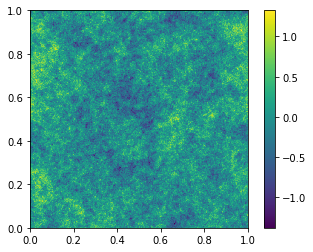

In [3]:
pb = pbox.PowerBox(
    N=512,                     # Number of grid-points in the box
    dim=2,                     # 2D box
    pk = lambda k: 0.1*k**-2., # The power-spectrum
    boxlength = 1.0,           # Size of the box (sets the units of k in pk)
    seed = 1010                # Set a seed to ensure the box looks the same every time (optional)
)

plt.imshow(pb.delta_x(),extent=(0,1,0,1))
plt.colorbar()
plt.show()

The ``delta_x`` output is *always* zero-mean, so it can be interpreted as an over-density field, $\rho(x)/\bar{\rho} -1$. The caveat to this is that an overdensity field is physically invalid below -1. To ensure the physical validity of the field, the option ``ensure_physical`` can be set, which clips the field: 

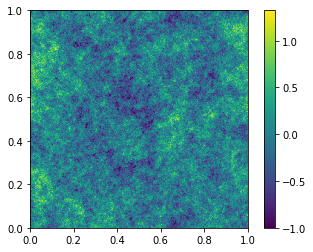

In [4]:
pb = pbox.PowerBox(
    N=512,                     # Number of grid-points in the box
    dim=2,                     # 2D box
    pk = lambda k: 0.1*k**-2., # The power-spectrum
    boxlength = 1.0,           # Size of the box (sets the units of k in pk)
    seed = 1010,               # Set a seed to ensure the box looks the same every time (optional)
    ensure_physical=True       # ** Ensure the delta_x is a physically valid over-density **
)
 

plt.imshow(pb.delta_x(),extent=(0,1,0,1))
plt.colorbar()
plt.show()

If you are actually dealing with over-densities, then this clipping solution is probably a bit hacky. What you want is a log-normal field...

## Create a 2D Log-Normal field with power-law power spectrum

The ``LogNormalPowerBox`` class is called in exactly the same way, but the resulting field has a log-normal pdf with the same power spectrum.

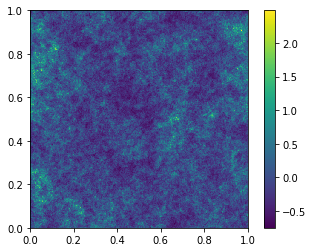

In [5]:
lnpb = pbox.LogNormalPowerBox(
    N=512,                     # Number of grid-points in the box
    dim=2,                     # 2D box
    pk = lambda k: 0.1*k**-2., # The power-spectrum
    boxlength = 1.0,           # Size of the box (sets the units of k in pk)
    seed = 1010                # Use the same seed as our powerbox
)
plt.imshow(lnpb.delta_x(),extent=(0,1,0,1))
plt.colorbar()
plt.show()

Again, the ``delta_x`` is zero-mean, but has a longer positive tail due to the log-normal nature of the distribution. This means it is always greater than -1, so that the over-density field is always physical.

## Create some discrete samples on the field

``powerbox`` lets you easily create samples that follow the field:

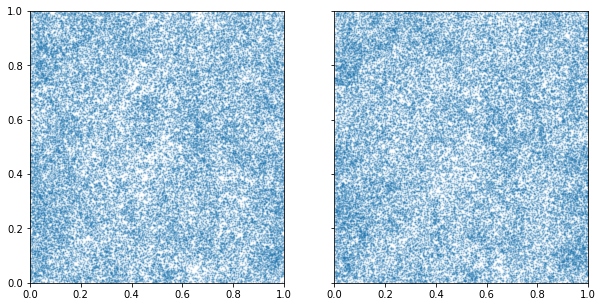

In [6]:
fig, ax = plt.subplots(1,2, sharex=True,sharey=True,gridspec_kw={"hspace":0}, subplot_kw={"ylim":(0,1),"xlim":(0,1)}, figsize=(10,5))

# Create a discrete sample using the PowerBox instance.
samples = pb.create_discrete_sample(nbar=50000,      # nbar specifies the number density
                                    min_at_zero=True  # by default the samples are centred at 0. This shifts them to be positive.
                                   ) 
ln_samples = lnpb.create_discrete_sample(nbar=50000, min_at_zero=True) 

# Plot the samples
ax[0].scatter(samples[:,0],samples[:,1], alpha=0.2,s=1)
ax[1].scatter(ln_samples[:,0],ln_samples[:,1],alpha=0.2,s=1)
plt.show()

Within each grid-cell, the placement of the samples is uniformly random. The samples can instead be placed on the cell edge by setting ``randomise_in_cell`` to ``False``.

## Check the power-spectrum of the field

``powerbox`` also contains a function for computing the (isotropic) power-spectrum of a field. This function accepts either a box defining the field values at every co-ordinate, *or* a set of discrete samples. In the latter case, the routine returns the power spectrum of over-densities, which matches the field that produced them. Let's go ahead and compute the power spectrum of our boxes, both from the samples and from the fields themselves:

In [7]:
from powerbox import get_power

In [8]:
# Only two arguments required when passing a field
p_k_field, bins_field = get_power(pb.delta_x(), pb.boxlength)
p_k_lnfield, bins_lnfield = get_power(lnpb.delta_x(), lnpb.boxlength)

# The number of grid points are also required when passing the samples
p_k_samples, bins_samples = get_power(samples, pb.boxlength,N=pb.N)
p_k_lnsamples, bins_lnsamples = get_power(ln_samples, lnpb.boxlength,N=lnpb.N)


Now we can plot them all together to ensure they line up:

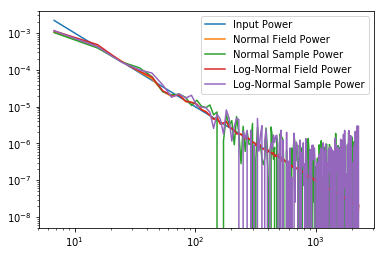

In [9]:
plt.plot(bins_field, 0.1*bins_field**-2., label="Input Power")

plt.plot(bins_field, p_k_field,label="Normal Field Power")
plt.plot(bins_samples, p_k_samples,label="Normal Sample Power")
plt.plot(bins_lnfield, p_k_lnfield,label="Log-Normal Field Power")
plt.plot(bins_lnsamples, p_k_lnsamples,label="Log-Normal Sample Power")

plt.legend()
plt.xscale('log')
plt.yscale('log')
